In [2324]:
import os
import contextily as ctx
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import sqrt
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error

# Random Forest

## Load data

In [2325]:
well_filter = 1

current_dir = os.getcwd()
path = os.path.join(current_dir, '../../data/aligned', f"merged_dataset_{well_filter}.csv")
df = pd.read_csv(path)
len(df)

192

In [2326]:
df.columns

Index(['bro-id', 'nitrate', 'geometry', 'date', 'soil region', 'landuse code',
       'population', 'groundwater depth', 'elevation', 'lon', 'lat',
       'precipitation', 'temperature', 'n deposition',
       'mainsoilclassification_1', 'organicmattercontent_1', 'density_1',
       'acidity_1'],
      dtype='object')

In [2327]:
df = df[df["soil region"] != "veen"]
len(df)

175

## Sort by date

In [2328]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

## Remove some columns and rows

--> By dropping Nan we exclude nitrate points that fall under city areas

In [2329]:
# df = df.drop(columns=['soil region', 'landuse code'])
df = df.drop(columns=['landuse code'])

df = df.dropna()
len(df)

118

## Add month and year as a feature

In [2330]:
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

## Change column type

In [2331]:
for col in ['soil region', 'landuse code', 'mainsoilclassification_1']:
    if col in df.columns:
        df[col] = df[col].astype('category')

## Remove nitrate outliers

<Axes: >

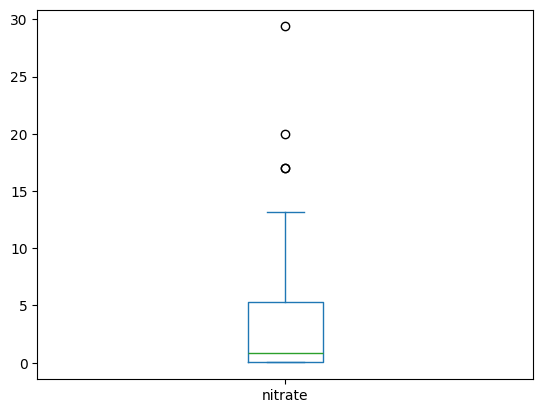

In [2332]:
df[["nitrate"]].plot(kind = "box")

In [2333]:
q1 = df["nitrate"].quantile(0.25)
q3 = df["nitrate"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["nitrate"] < lower_bound) | (df["nitrate"] > upper_bound)]
print(f"Outliers found: {len(outliers)}")
outliers

Outliers found: 4


,bro-id,nitrate,geometry,date,soil region,population,groundwater depth,elevation,lon,lat,precipitation,temperature,n deposition,mainsoilclassification_1,organicmattercontent_1,density_1,acidity_1,month,year
0,GAR000000000784,29.37,POINT (5.600793941 51.962453539),2012-02-23 10:00:00+00:00,zand,40.0,6.838178,12.048532,5.600794,51.962454,8.75,29.466667,27.383685,Dikke eerdgronden,2.0,1.425,4.5,2,2012
72,GAR000000000785,20.00,POINT (5.600793941 51.962453539),2015-06-16 10:00:00+00:00,zand,35.0,6.634271,12.048532,5.600794,51.962454,1.00,125.166667,25.198593,Dikke eerdgronden,2.0,1.425,4.5,6,2015
131,GAR000000000786,17.00,POINT (5.600793941 51.962453539),2018-05-18 10:00:00+00:00,zand,40.0,6.654944,12.048532,5.600794,51.962454,0.25,115.566667,25.716852,Dikke eerdgronden,2.0,1.425,4.5,5,2018
150,GAR000000000819,17.00,POINT (5.54652435 51.966979885),2018-05-28 10:00:00+00:00,zand,55.0,9.291444,16.680454,5.546524,51.966980,6.00,137.700000,28.616301,Dikke eerdgronden,2.0,1.425,4.5,5,2018


In [2334]:
# top_nitrate_outliers = list(df["nitrate"].sort_values()[-len(outliers):].index)
# top_nitrate_outliers
# df = df.drop(top_nitrate_outliers)
# len(df)

## Test / train split

In [2335]:
n = len(df)
train_size = int(n * 0.7)

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")


Train: 82
Test: 36


In [2336]:
X_train = train_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_train = train_df["nitrate"]

X_test = test_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_test = test_df["nitrate"]

## Preprocess data

In [2337]:
categorical_cols = X_train.select_dtypes(include="category").columns.tolist()
numerical_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

In [2338]:
print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)
print("All X_train columns:", X_train.columns.tolist())

Categorical: ['soil region', 'mainsoilclassification_1']
Numerical: ['population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'organicmattercontent_1', 'density_1', 'acidity_1']
All X_train columns: ['soil region', 'population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1', 'density_1', 'acidity_1']


In [2339]:
preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num_scaler", StandardScaler(), numerical_cols)
])

## Initialize model

In [2340]:
rf_model = RandomForestRegressor(random_state=4, oob_score=False)

In [2341]:
pipe = Pipeline([
    ("prep", preprocessor),
    ("rf", rf_model)
])

full_pipeline = TransformedTargetRegressor(
    regressor=pipe,
    func=np.log1p,
    inverse_func=np.expm1
)

In [2342]:
param_grid = {
    "regressor__rf__n_estimators": [50, 100, 150, 200],
    "regressor__rf__max_features": ["sqrt", 0.5, 1],
    "regressor__rf__max_depth": [None, 5, 10, 15],
    "regressor__rf__min_samples_split": [2, 4, 6],
    "regressor__rf__min_samples_leaf": [1, 2, 3]
}

## Hyperparameter tuning

In [2343]:
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_grid,
    n_iter=60,
    cv=tscv,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    n_jobs=-1,
    random_state=9,
    verbose=1
)
search.fit(X_train, y_train)
best_model = search.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [2346]:
print("Best CV MAE:", -search.best_score_)
print("Best params:", search.best_params_)

Best CV MAE: 1.763879310243722
Best params: {'regressor__rf__n_estimators': 200, 'regressor__rf__min_samples_split': 6, 'regressor__rf__min_samples_leaf': 1, 'regressor__rf__max_features': 0.5, 'regressor__rf__max_depth': 5}


## Learning curve

In [2347]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [2348]:
n = len(X_train)

train_errors = []
val_errors = []

for frac in train_sizes:
    split_idx = int(frac * n)
    X_subset = X_train.iloc[:split_idx]
    y_subset = y_train.iloc[:split_idx]

    tscv = TimeSeriesSplit(n_splits=7)
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_subset):
        X_tr, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
        y_tr, y_val = y_subset.iloc[train_idx], y_subset.iloc[val_idx]

        model = clone(best_model)
        model.fit(X_tr, y_tr)

        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        fold_train_scores.append(mean_absolute_error(y_tr, y_tr_pred))
        fold_val_scores.append(mean_absolute_error(y_val, y_val_pred))

    train_errors.append(np.mean(fold_train_scores))
    val_errors.append(np.mean(fold_val_scores))

In [2349]:
val_errors

[5.437579494473562,
 1.6575384594728158,
 2.4527774130816877,
 2.3343073960913037,
 2.223620727451624,
 2.324198913855311,
 2.3410418871075023,
 2.2203797265828626,
 2.1151801080723915,
 2.021700655809074]

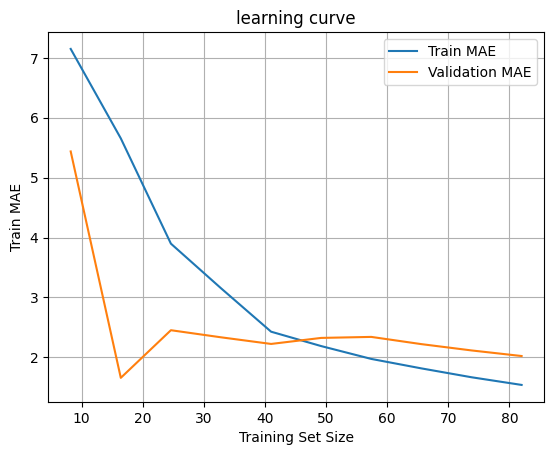

In [2350]:
plt.plot(train_sizes * len(X_train), train_errors, label="Train MAE")
plt.plot(train_sizes * len(X_train), val_errors, label="Validation MAE")
plt.xlabel("Training Set Size")
plt.ylabel("Train MAE")
plt.title("learning curve")
plt.legend()
plt.grid(True)
plt.show()

## Train model

In [2351]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['soil '
                                                                                        'region',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        'groundwater '
                                                                                        'depth',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',
                                                                                        'density_1',
                                                                                        'acidity_1'])])),
                                                     ('rf',
                                                      RandomForestRegressor(max_depth=5,
                                                                            max_features=0.5,
                                                                            min_samples_split=6,
                                                                            n_estimators=200,
                                                                            random_state=4))]))

## Final Train score

In [2352]:
pred_train = best_model.predict(X_train)

print("Train R2:", r2_score(y_train, pred_train))
print("Train MAE:", mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(y_train, pred_train)))

Train R2: 0.8180117726906033
Train MAE: 1.0402164320350276
Test RMSE: 2.2286618766665183


## Final Test score

In [2353]:
pred_nitrate = best_model.predict(X_test)

print("Test R2:", r2_score(y_test,  pred_nitrate))
print("Test MAE:",mean_absolute_error(y_test, pred_nitrate))
print("Test RMSE:", sqrt(mean_squared_error(y_test, pred_nitrate)))

Test R2: 0.7922845638110161
Test MAE: 1.1704070022210928
Test RMSE: 1.9158810613397603


## Real vs Predicted

<Axes: xlabel='nitrate', ylabel='nitrate'>

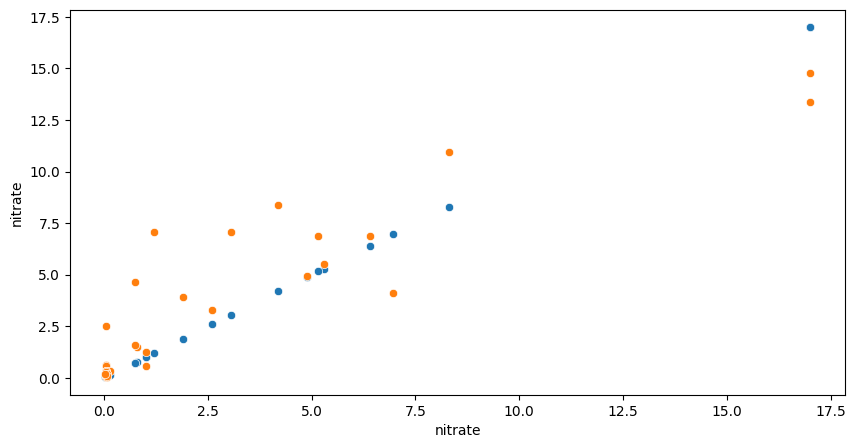

In [2354]:
fix, ax = plt.subplots(figsize= (10,5))

sns.scatterplot(x = y_test, y = y_test, ax = ax)
sns.scatterplot(x = y_test, y = pred_nitrate, ax = ax)

## Residuals

Text(0, 0.5, 'Residuals')

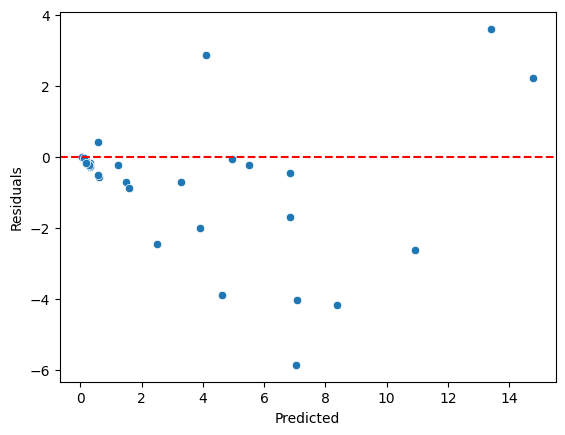

In [2355]:
preds = best_model.predict(X_test)
residuals = y_test - preds
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals")

## Predictions on the map

In [2356]:
coords = test_df[["lon", "lat"]].reset_index(drop=True)

print(len(coords['lon']))
print(len(coords['lat']))
print(len(np.expm1(pred_nitrate)))
print(len(np.expm1(y_test)))

36
36
36
36


In [2357]:
#extract 'lon' and 'lat' from test_df
coords = test_df[["lon", "lat"]].reset_index(drop=True)

# construct new dataframe with predictions, real values and locations
gdf = gpd.GeoDataFrame({
    'lon': coords['lon'],
    'lat': coords['lat'],
    'nitrate_pred': pred_nitrate,
    'nitrate_true': y_test.reset_index(drop=True)
}, geometry=gpd.points_from_xy(coords["lon"], coords["lat"]))

gdf.crs = "EPSG:4326"

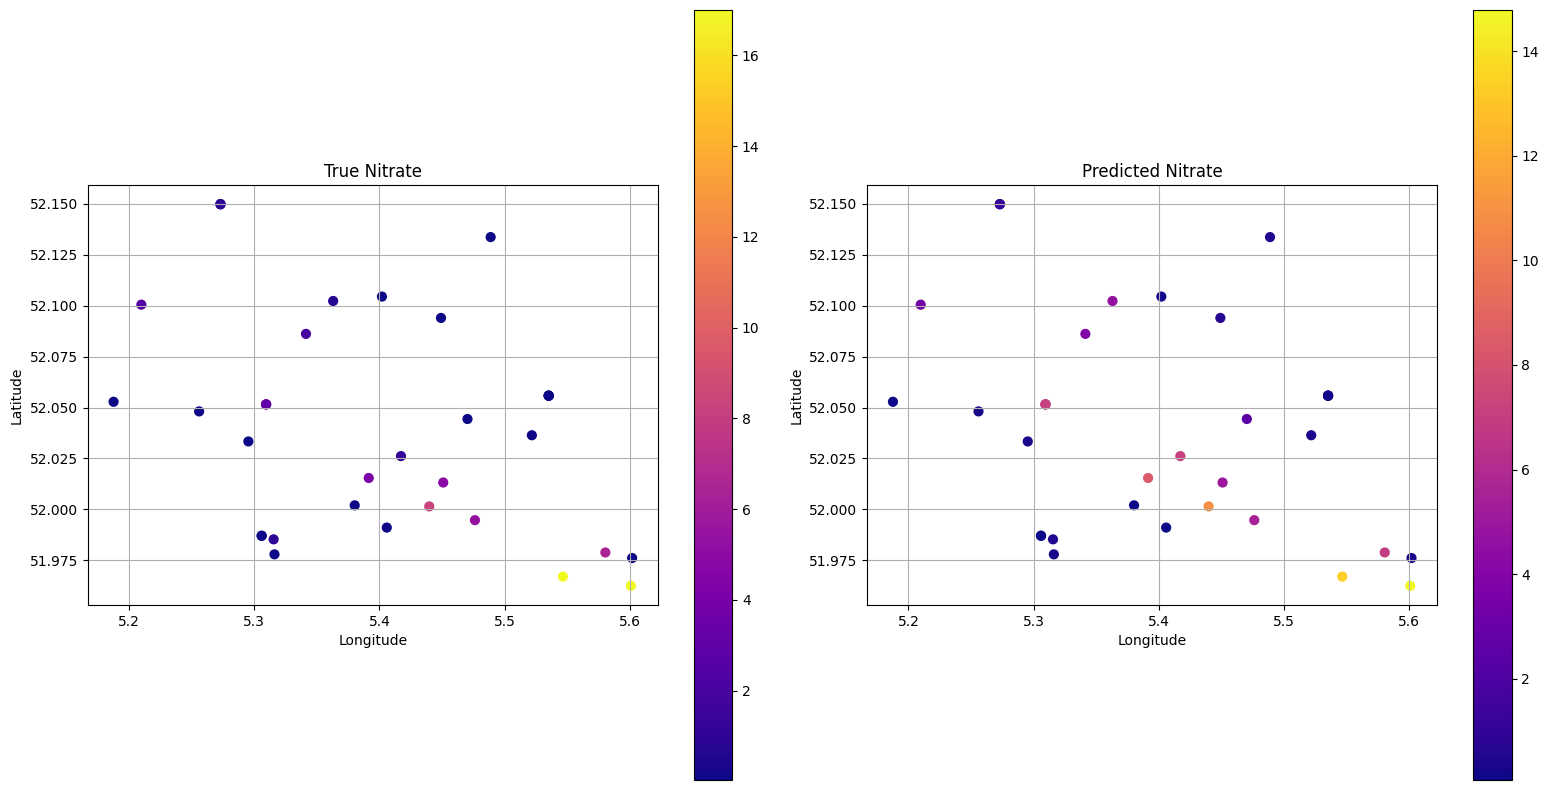

In [2358]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
axs[0].set_title("True Nitrate")

gdf.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

plt.tight_layout()
plt.show()

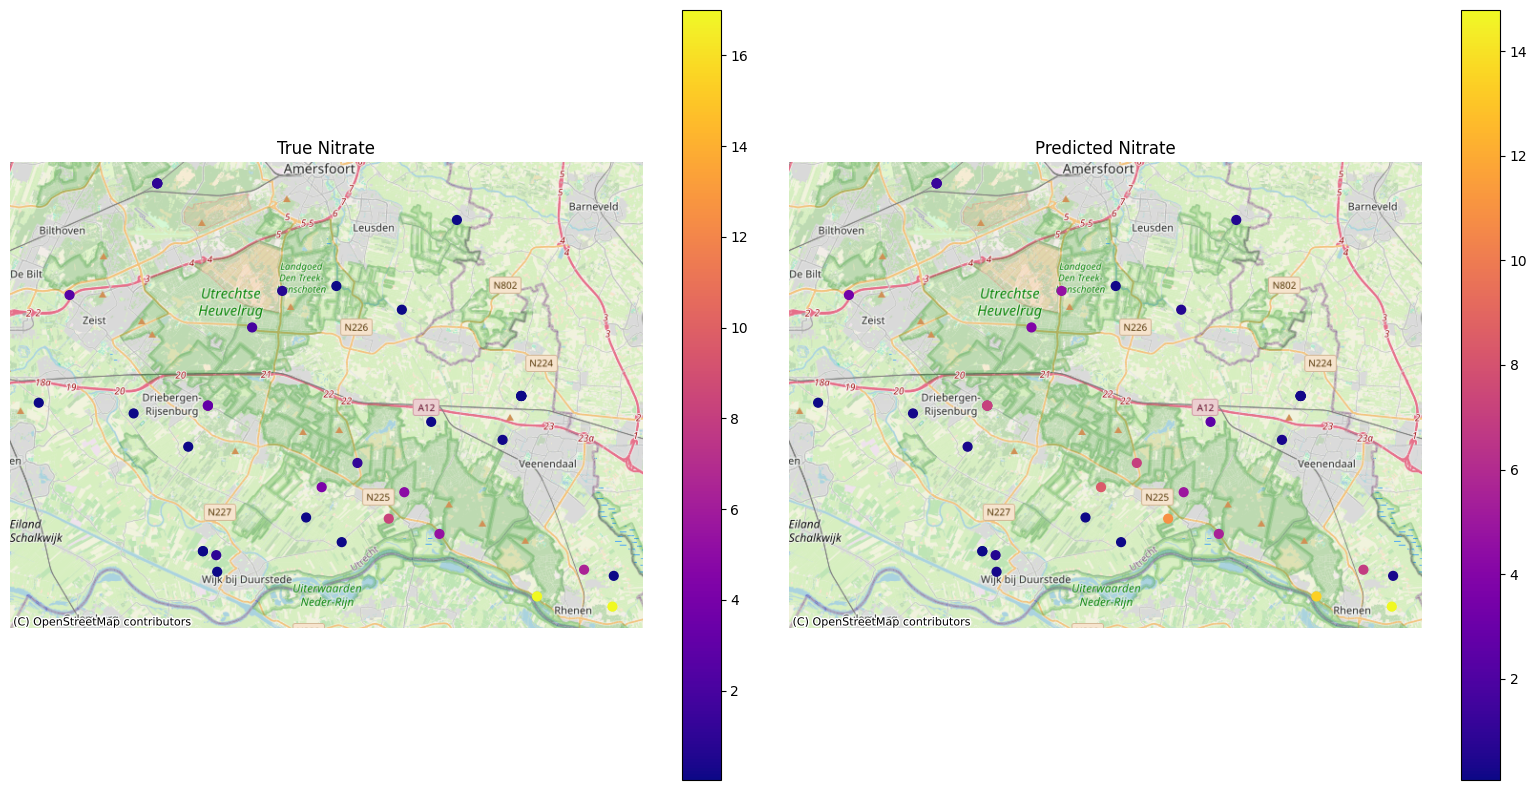

In [2359]:
gdf_3857 = gdf.to_crs(epsg=3857)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

## Feature importances

--> Gain (by default) how much each feature, on average, reduces the impurity (MSE or Gini)

In [2360]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['soil '
                                                                                        'region',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        'groundwater '
                                                                                        'depth',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',
                                                                                        'density_1',
                                                                                        'acidity_1'])])),
                                                     ('rf',
                                                      RandomForestRegressor(max_depth=5,
                                                                            max_features=0.5,
                                                                            min_samples_split=6,
                                                                            n_estimators=200,
                                                                            random_state=4))]))

In [2361]:
if isinstance(best_model, TransformedTargetRegressor):
    print("Yes, this is a TransformedTargetRegressor.")
else:
    print("Nope, it's not.")

Yes, this is a TransformedTargetRegressor.


In [2362]:
inner_pipeline = best_model.regressor_
fitted_preprocessor = inner_pipeline.named_steps['prep']
fitted_model = inner_pipeline.named_steps['rf']

feature_names = fitted_preprocessor.get_feature_names_out()

importances = fitted_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

                                              feature  importance
15                              num_scaler__acidity_1    0.359818
9                               num_scaler__elevation    0.232257
14                              num_scaler__density_1    0.114192
8                       num_scaler__groundwater depth    0.097988
13                 num_scaler__organicmattercontent_1    0.060349
7                              num_scaler__population    0.042537
12                           num_scaler__n deposition    0.018064
10                          num_scaler__precipitation    0.017727
11                            num_scaler__temperature    0.017389
6   cat_ohe__mainsoilclassification_1_Rivierkleigr...    0.010465
2   cat_ohe__mainsoilclassification_1_Dikke eerdgr...    0.007459
3   cat_ohe__mainsoilclassification_1_Kalkloze zan...    0.005827
4   cat_ohe__mainsoilclassification_1_Moerige gronden    0.005779
5     cat_ohe__mainsoilclassification_1_Podzolgronden    0.004093
0         

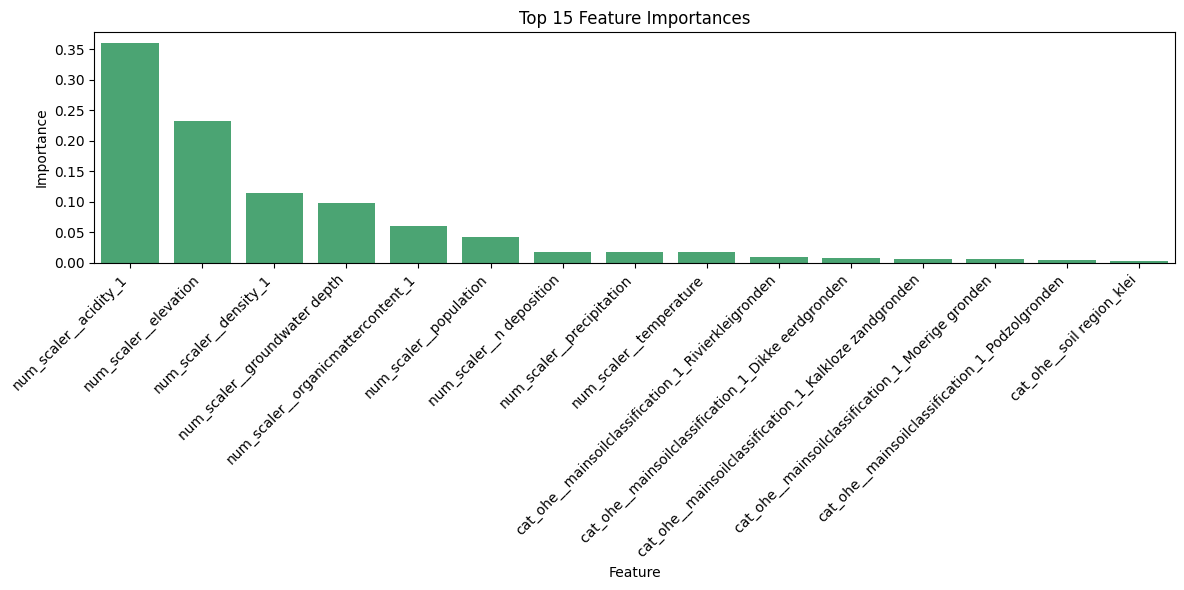

In [2364]:
# Build and plot the importance DataFrame
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="Feature", y="Importance", data=fi_df.head(15), color="mediumseagreen")
plt.xticks(rotation=45, ha='right')
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()


In [1167]:
# --- Keep:
# organiccontent
# elevation
# soil code
# acidity
# groundwater depth
# density
# population
# precipitation
# n_deposition
# temperature

# --- Remove:
# landuse
# soil region
# month